In [14]:
import sys
import os
import pathlib
import numpy as np
import json
import matplotlib.pyplot as plt
from kneed import KneeLocator
from scipy.ndimage import uniform_filter1d
from scipy import sparse

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
fig_width = 7.5  # inches
fig_height = 5  # inches
fig_dpi = 350

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,

    # Fonts
    'font.size': 18,

    # Axes
    'axes.labelsize': 16,
    'axes.titlesize': 13,
    'axes.linewidth': 1,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 1,
    'grid.color': 'gray',

    # Legend
    'legend.fontsize': 16,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,

    # Lines
    'lines.linewidth': 2.0,
    'lines.markersize': 4,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
})

In [17]:
path_save = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/fluffy-train")

In [18]:
mallet_path = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/data/models/mallet")
ctm_path = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/data/models/ctm")
bert_path = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/data/models/trained/bertopic_wiki_50_ctm_emb_pre_umap_cuml")

In [19]:
def load_model_info(model_path):
    if model_path.stem == "mallet":
        thetas = np.load(model_path / "doctopics.npz.npy")
        betas = np.load(model_path / "beta.npy")
    elif model_path.stem == "ctm":
        thetas = np.load(model_path / "train.theta.npy")
        betas = np.load(model_path / "beta.npy")
    else:
        thetas = sparse.load_npz(pathlib.Path(model_path) / "thetas.npz").toarray()
        betas = np.load(model_path / "betas.npy")
    
    try:
        with open(model_path / "vocab.json") as infile:
            vocab_w2id = json.load(infile)
    except:
        vocab_w2id = {}
        with (pathlib.Path(model_path)/'vocab.txt').open('r', encoding='utf8') as fin:
            for i, line in enumerate(fin):
                wd = line.strip()
                vocab_w2id[wd] = i
    
    #bow = np.load(model_path / "bow_mat.npy")
    
    vocab_id2w = dict(zip(vocab_w2id.values(), vocab_w2id.keys()))
    keys = [
        [vocab_id2w[idx]
            for idx in row.argsort()[::-1][:15]]
        for row in betas
    ]
        
    return thetas, betas, vocab_w2id, keys

In [20]:
def thrFig(thetas32, thetas_thr=3e-3, poly_degree=3, smoothing_window=5, do_knee=True):
    significant_docs = {}
    all_elbows = []
    
    for k in range(len(thetas32.T)):
        allvalues = np.sort(thetas32[:, k].flatten())
        step = int(np.round(len(allvalues) / 1000))
        x_values = allvalues[::step]
        y_values = (100 / len(allvalues)) * np.arange(0, len(allvalues))[::step]
        
        # Apply smoothing
        y_values_smooth = uniform_filter1d(y_values, size=smoothing_window)

        plt.semilogx(x_values, y_values_smooth)
        
        if do_knee:
            # Using KneeLocator to find the elbow point
            kneedle = KneeLocator(x_values, y_values_smooth, curve='convex', direction='increasing', interp_method='polynomial', polynomial_degree=poly_degree)
            elbow = kneedle.elbow
            if elbow is not None:
                all_elbows.append(elbow)

                # Filter document indices based on the elbow point (keeping values above the elbow)
                significant_docs[k] = np.where(thetas32[:, k] >= elbow)[0]

        # Plot elbows
        # for elbow in all_elbows:
        #     if elbow:
        #         plt.semilogx([elbow, elbow], [0, 100], 'g--', label=f'Elbow {elbow}')

    plt.show()
        
    return significant_docs, all_elbows


In [21]:
def SaveThrFig(thetas32, plotFile, thetas_thr=0.003):
    allvalues = np.sort(thetas32.flatten())
    step = int(np.round(len(allvalues) / 1000))
    plt.semilogx(allvalues[::step], (100 / len(allvalues)) * np.arange(0, len(allvalues))[::step])
    plt.semilogx([thetas_thr, thetas_thr], [0, 100], 'r')
    
    # Adding x and y labels
    plt.xlabel('Document-topic distribution values ($\\rho$)')
    plt.ylabel('Elements in ${\\theta_{1:D}}$ smaller than $\\rho$ (%)')
    
    plt.show()
    plt.savefig(plotFile)
    plt.close()

def SaveThrFig(thetas32, plotFile, thetas_thr=0.1):
    allvalues = np.sort(thetas32.flatten())
    
    # Verify the range of allvalues
    print(f"Min value: {allvalues.min()}, Max value: {allvalues.max()}")
    
    step = int(np.round(len(allvalues) / 1000))
    
    # Plot the sorted values
    plt.semilogx(allvalues[::step], (1 / len(allvalues)) * np.arange(0, len(allvalues))[::step], label='CDF')
    
    # Plot the threshold line
    plt.semilogx([thetas_thr, thetas_thr], [0, 1], 'r', label=f'Threshold: {thetas_thr}')
    
    # Adding x and y labels
    plt.xlabel('Document-topic distribution values ($\\rho$)')
    plt.ylabel('Elements in ${\\theta_{1:D}}$ smaller than $\\rho$')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    # Show the plot
    #plt.show()
    
    # Save the plot to file
    plt.savefig(plotFile)
    plt.close()

In [22]:
thetas_mallet, betas_mallet, vocab_w2id_mallet, keys_mallet = load_model_info(mallet_path)
thetas_ctm, betas_ctm, vocab_w2id_ctm, keys_ctm = load_model_info(ctm_path)
thetas_bt, betas_bt, vocab_w2id_bt, keys_bt = load_model_info(bert_path)

In [23]:
thetas_mallet.shape

(14290, 50)

Min value: 9.460147794015938e-07, Max value: 0.999596118927002


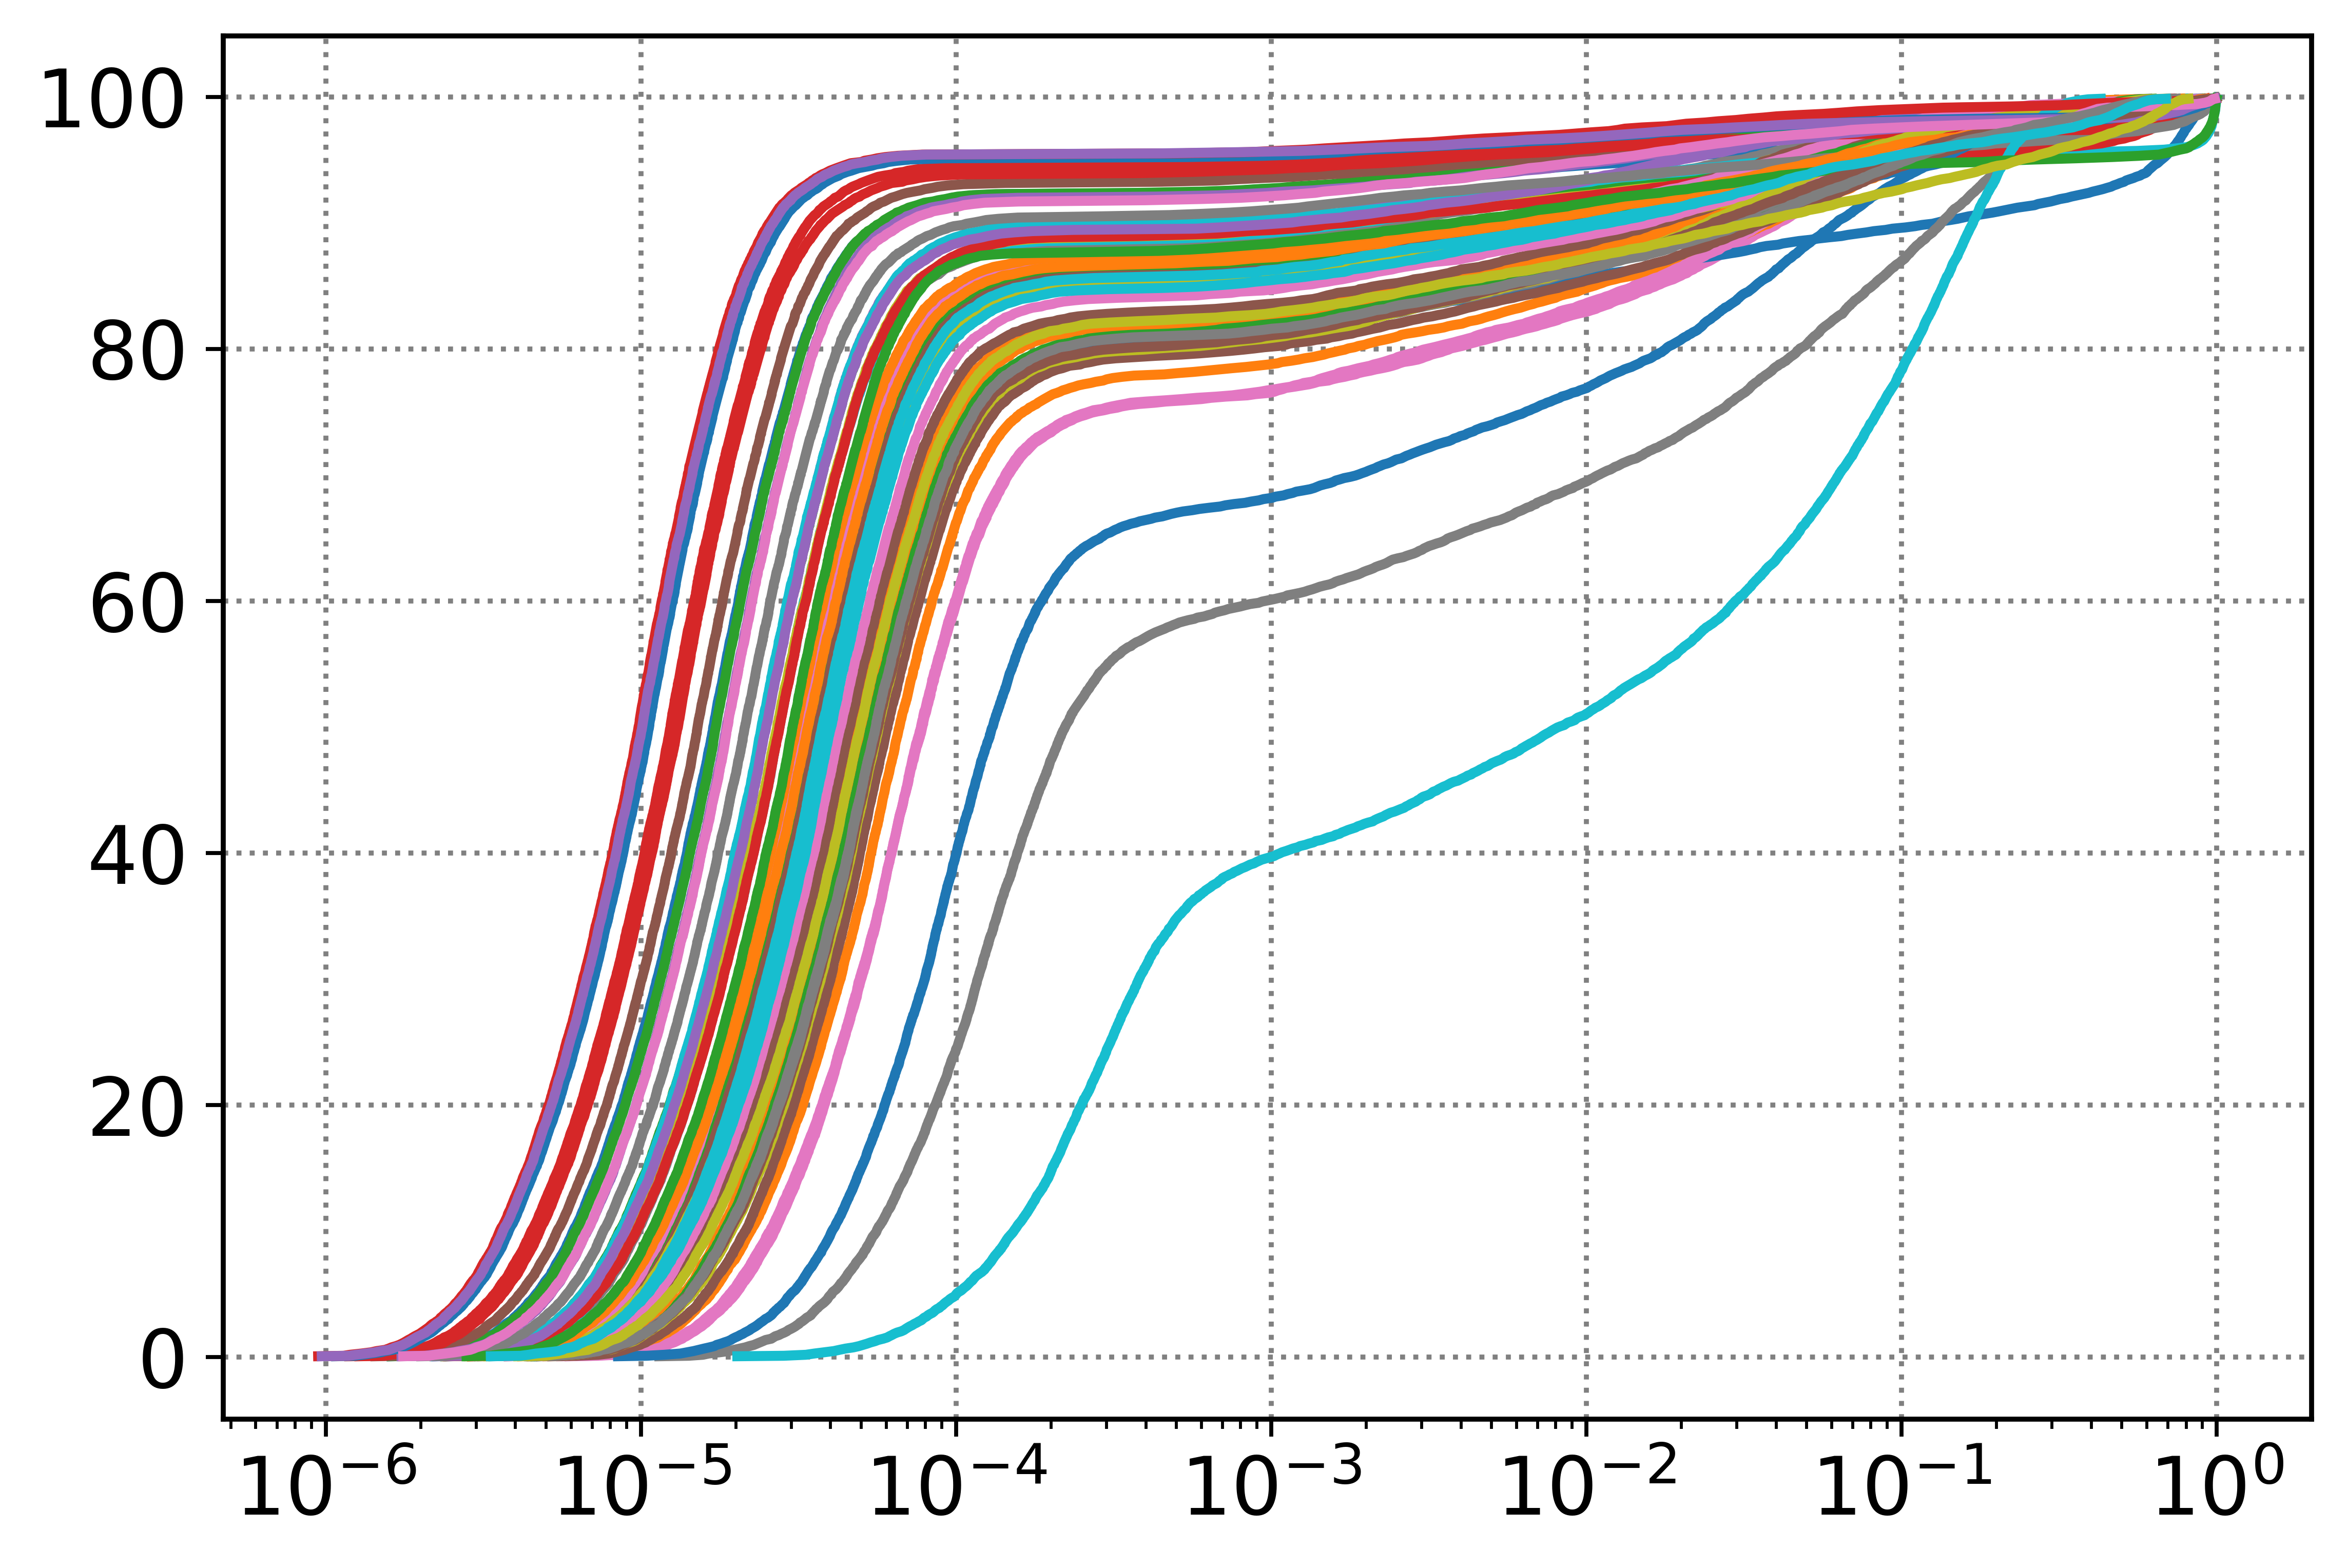

ELBOWS:  [0.7792659, 0.687971, 0.692486, 0.8120671, 0.75786465, 0.7611834, 0.5221809, 0.78930014, 0.6889924, 0.68035465, 0.72952235, 0.540052, 0.6712624, 0.740602, 0.7734349, 0.5962516, 0.6497761, 0.40709585, 0.6759843, 0.8499076, 0.6972453, 0.5429293, 0.74061453, 0.7072606, 0.65133816, 0.76090205, 0.5601941, 0.7940227, 0.56310815, 0.58321196, 0.6476571, 0.5398924, 0.45741257, 0.7758262, 0.77528656, 0.51687634, 0.6789173, 0.5400802, 0.49007687, 0.27168533, 0.80979663, 0.6835376, 0.82513237, 0.6695635, 0.79128534, 0.72940254, 0.7290348, 0.5003278, 0.59641635, 0.5038837]
Significant documents for topic 0: 206
Significant documents for topic 1: 66
Significant documents for topic 2: 66
Significant documents for topic 3: 66
Significant documents for topic 4: 108
Significant documents for topic 5: 136
Significant documents for topic 6: 80
Significant documents for topic 7: 80
Significant documents for topic 8: 108
Significant documents for topic 9: 108
Significant documents for topic 10: 570

In [24]:
SaveThrFig(thetas_mallet, path_save.joinpath("mallet").as_posix(),thetas_thr=1e-3)
significant_docs, elbows = thrFig(thetas_mallet)

print("ELBOWS: ", elbows)

for topic, docs in significant_docs.items():
    print(f"Significant documents for topic {topic}: {len(docs)}")

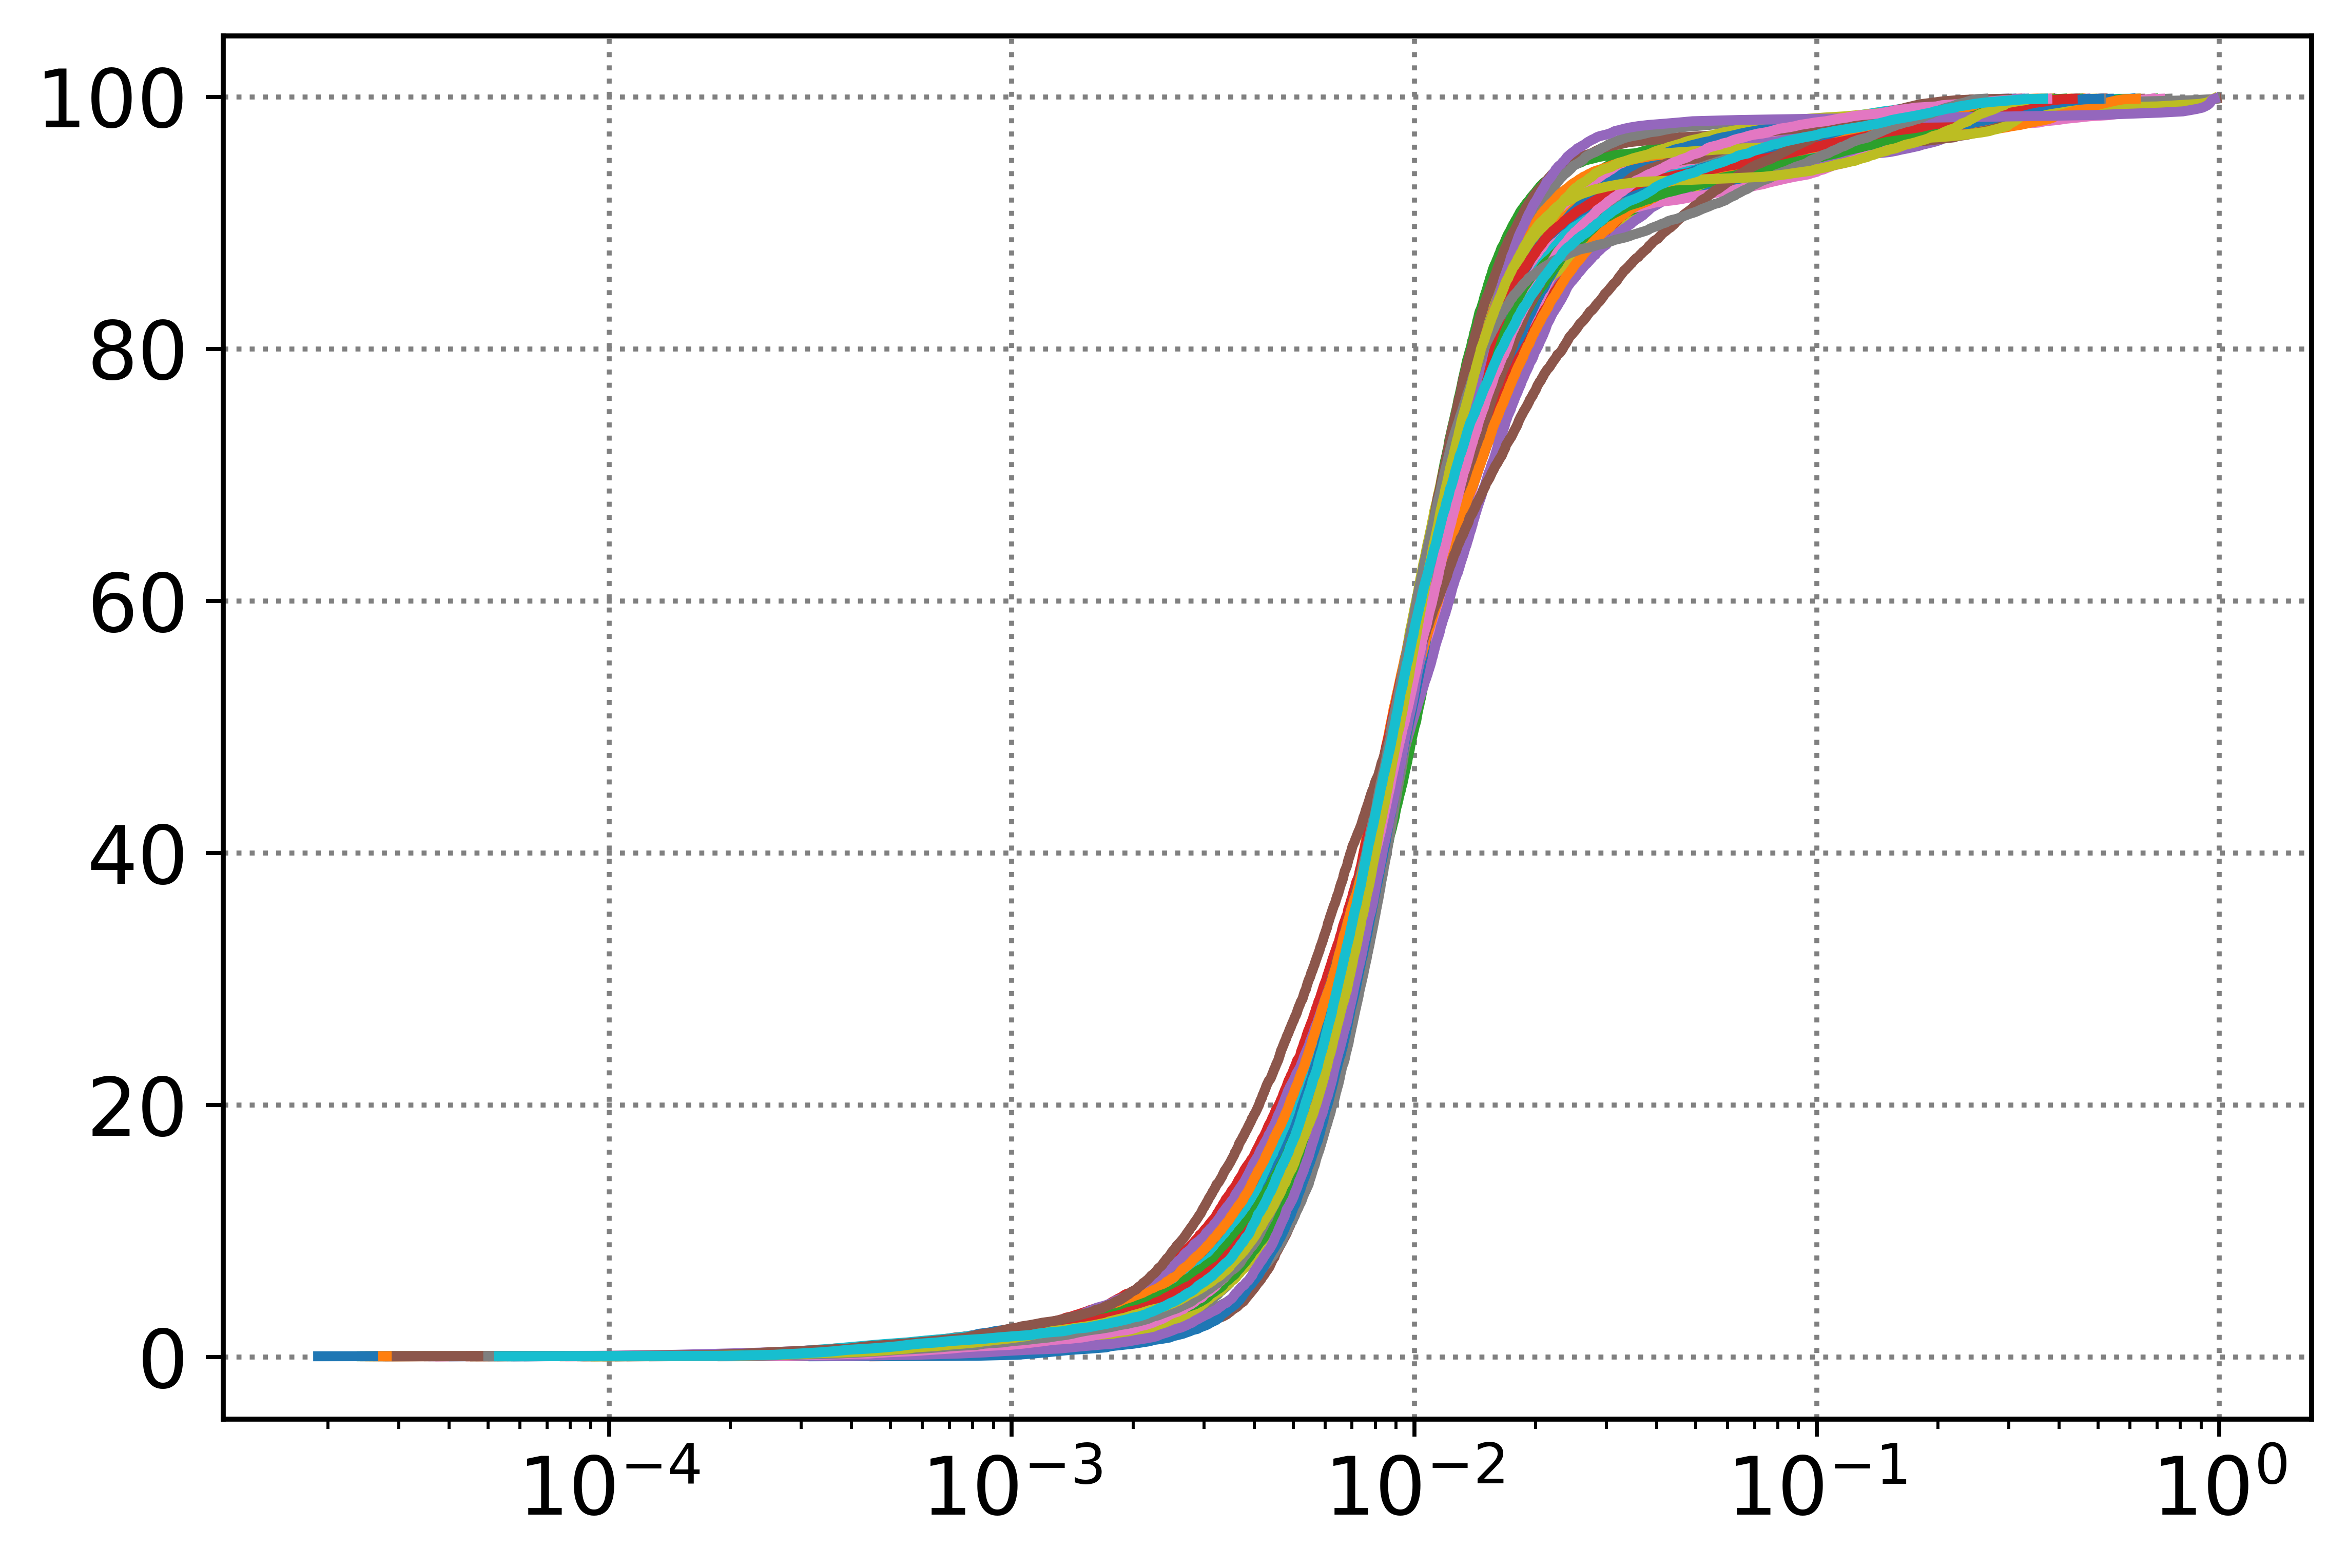

Min value: 1.8919544385198605e-05, Max value: 0.9954009354114532
ELBOWS:  [0.21540258154273034, 0.32892355471849444, 0.5073715180158616, 0.22693911269307138, 0.27995420545339583, 0.46867322623729707, 0.2570363752543926, 0.3674131497740746, 0.254582579433918, 0.3728777602314949, 0.23450780659914017, 0.2405892215669155, 0.4557384788990021, 0.37015649676322937, 0.22621928080916404, 0.3693623349070549, 0.5339368984103203, 0.5247363775968552, 0.3420946910977364, 0.24989537373185158, 0.4486656293272972, 0.33252125829458234, 0.3125187560915947, 0.37959459275007246, 0.33774556443095205, 0.6631326466798783, 0.5282246932387352, 0.6397886246442794, 0.7872547239065171, 0.3137896090745926, 0.4102339372038841, 0.4583629921078682, 0.31538893431425097, 0.31142088696360587, 0.20365871489048004, 0.2920213095843792, 0.2672708109021187, 0.36853202879428865, 0.2883221715688705, 0.2651862591505051, 0.3675933241844177, 0.30251180604100225, 0.2923930995166302, 0.31072106435894964, 0.8115506947040558, 0.204039

In [25]:
significant_docs, elbows = thrFig(thetas_ctm,  thetas_thr=2)
SaveThrFig(thetas_ctm, path_save.joinpath("ctm").as_posix(),thetas_thr=2e-2)


print("ELBOWS: ", elbows)

for topic, docs in significant_docs.items():
    print(f"Significant documents for topic {topic}: {len(docs)}")

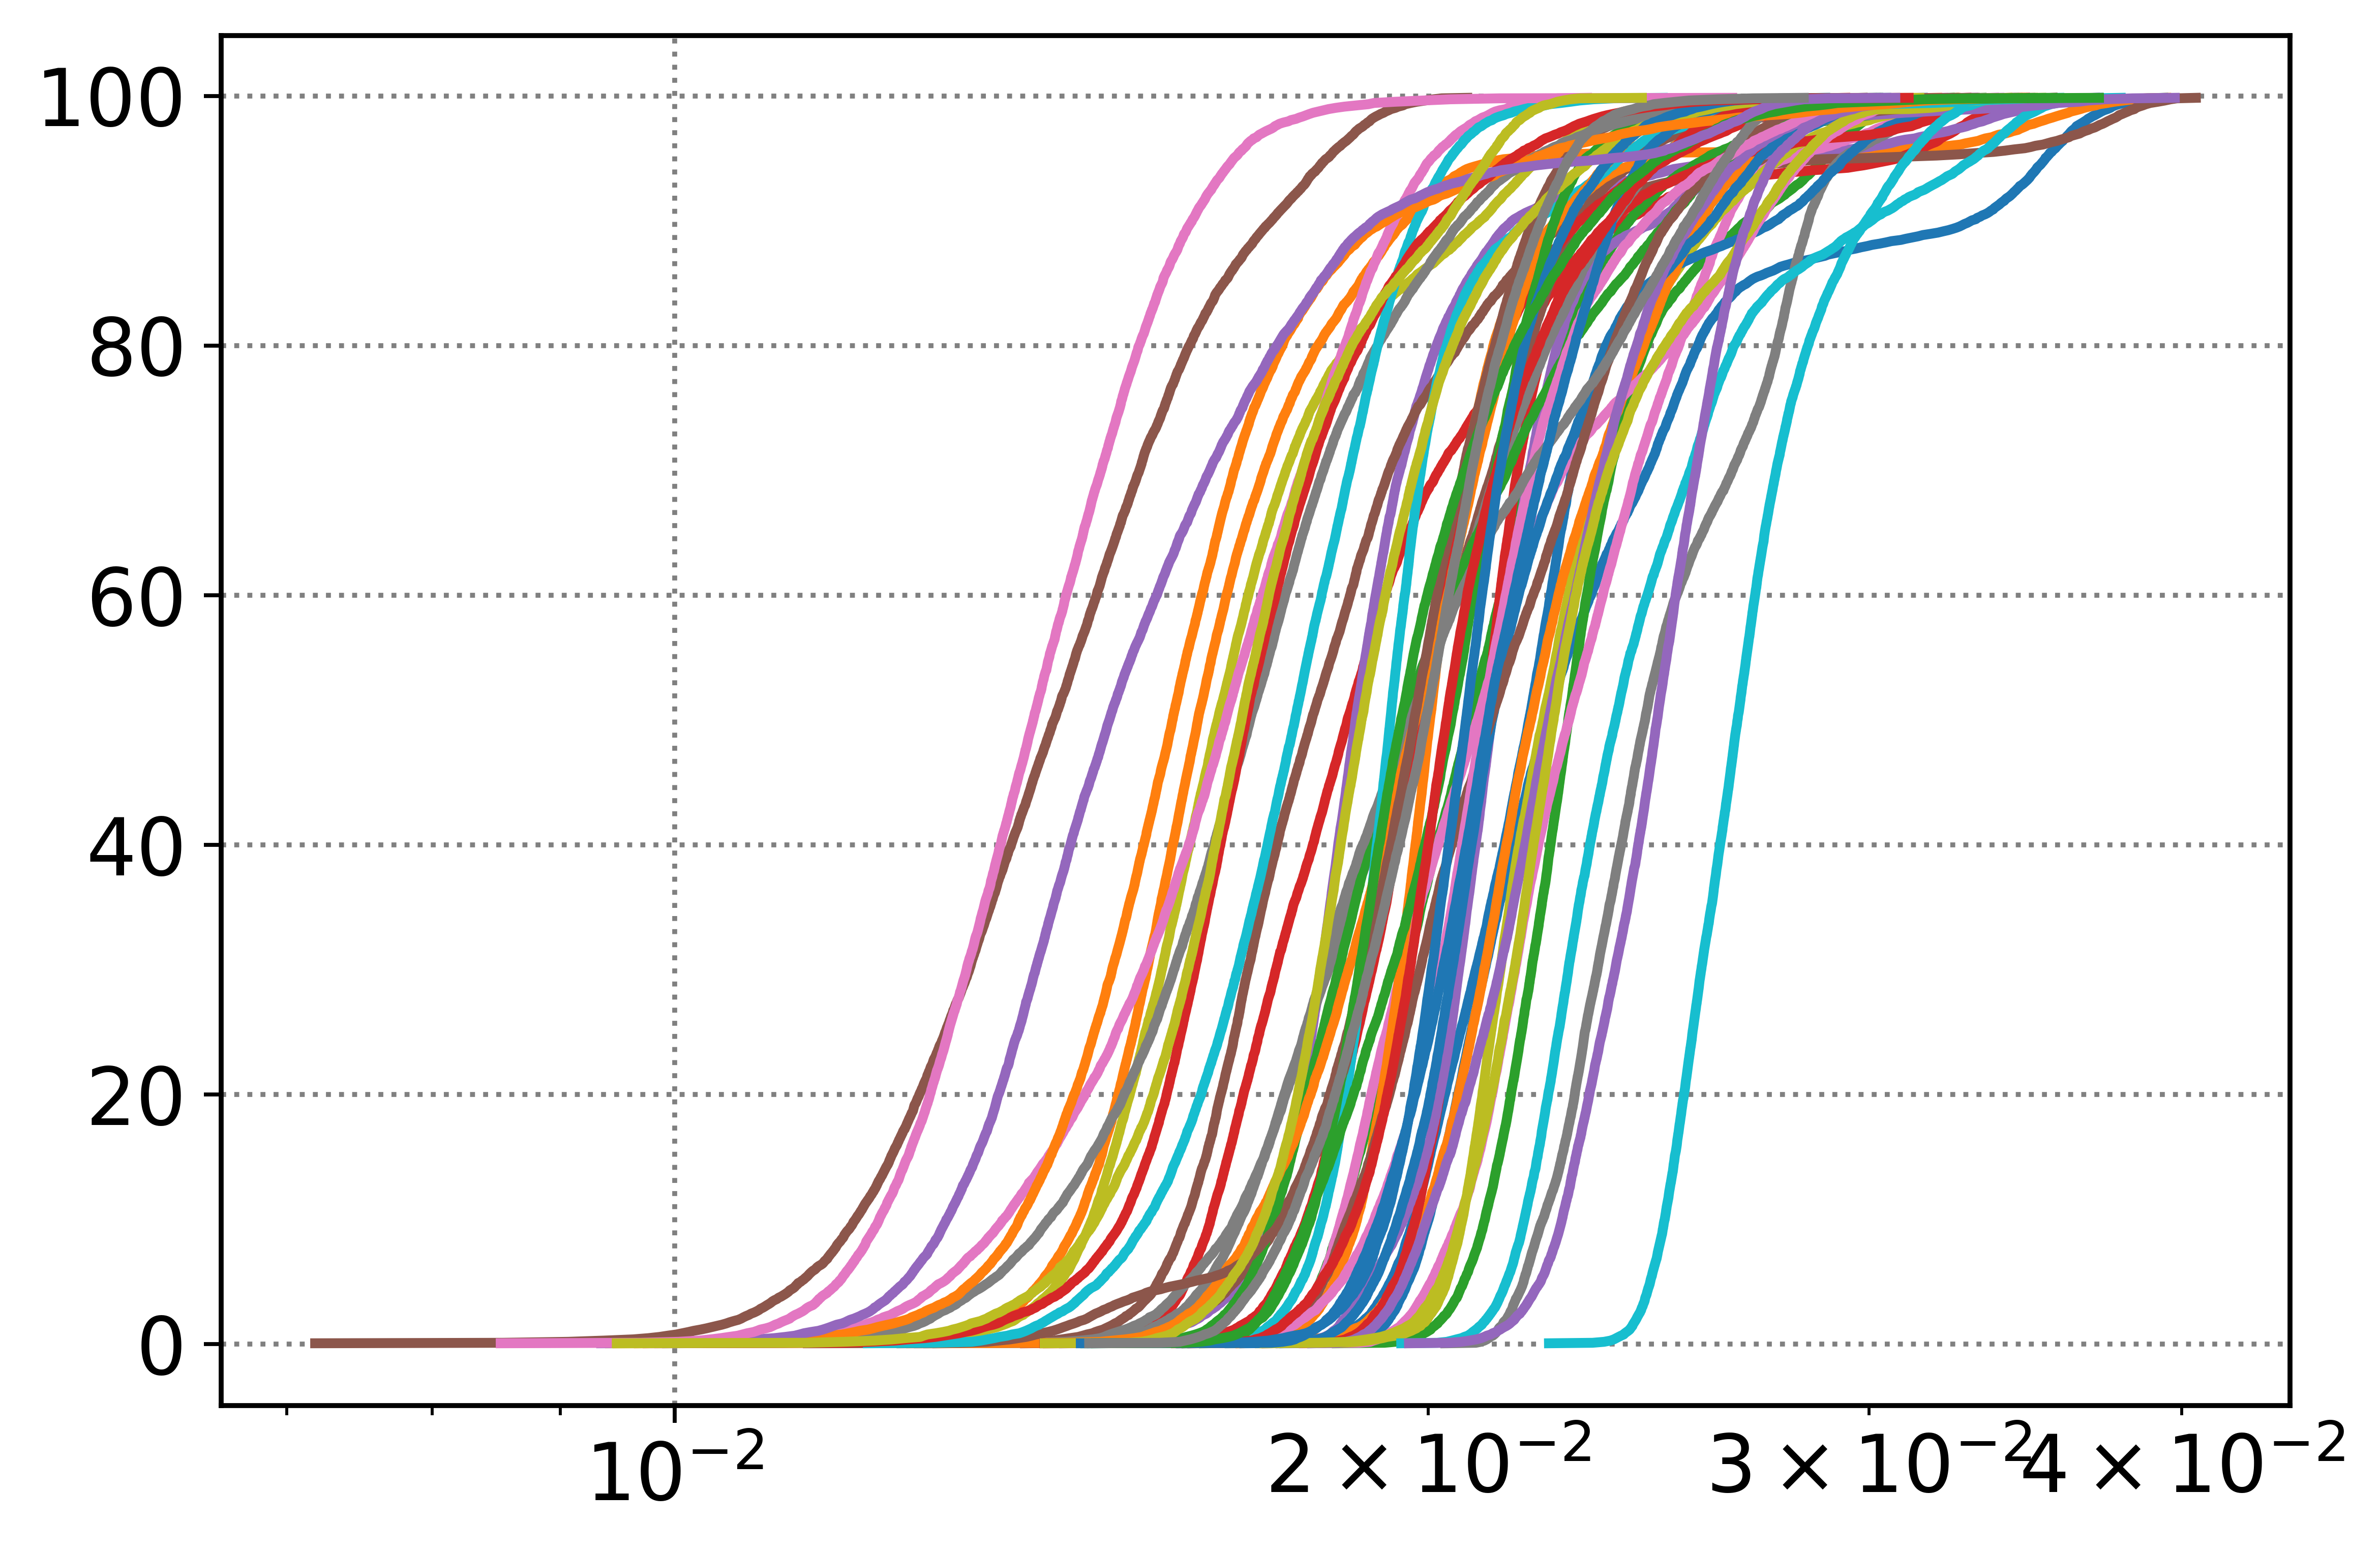

Min value: 0.007184803239867564, Max value: 0.04361054696265283
ELBOWS:  []


In [26]:
significant_docs, elbows = thrFig(thetas_bt, do_knee=False)
SaveThrFig(thetas_bt, path_save.joinpath("bertopic").as_posix(),thetas_thr=2*1e-2)


print("ELBOWS: ", elbows)

for topic, docs in significant_docs.items():
    print(f"Significant documents for topic {topic}: {len(docs)}")

For BERTopic, most lines near the top indicating a few documents strongly represent each topic (makes sense since it's an approximation after hard clustering).